## 5. Final Model Selection & Comprehensive Evaluation

FINAL MODEL RANKING (All Models)
                    R2_Test           MAE          RMSE
Stacking_Ensemble  0.772505  44175.724893  65340.857626
Voting_Ensemble    0.772072  42916.360653  64049.599581
GradientBoosting   0.764382  43922.548767   72405.88384
SVR                0.746703  44250.931835  67074.903656
Ridge              0.732687  49095.914059  74010.307456
RandomForest       0.721595  46023.032893  67285.004954
AdaBoost           0.628578  55734.992772  75276.447549
ElasticNet         0.608185  54944.656872  70381.826803

🏆 CHAMPION MODEL: Stacking_Ensemble
   R² Score: 0.7725
   MAE: 44,176 TND
   RMSE: 65,341 TND


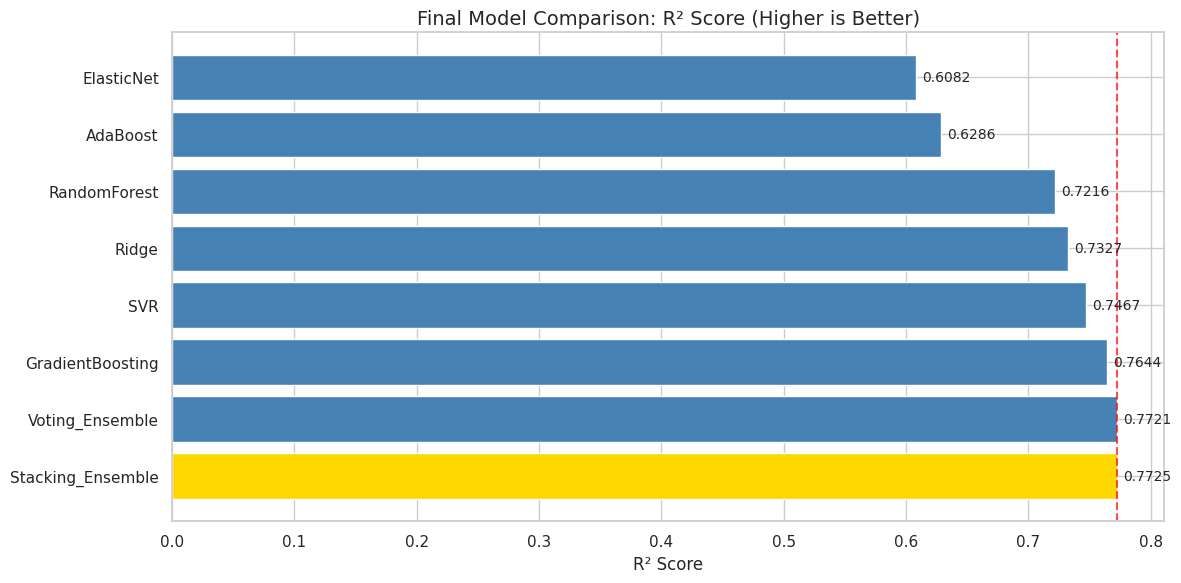

In [187]:
# --- Final Comparison: All Models Including Ensembles ---
final_comparison = pd.DataFrame(model_results).T[['R2_Test', 'MAE', 'RMSE']].dropna(subset=['R2_Test'])
final_comparison = final_comparison.sort_values('R2_Test', ascending=False)

print("="*70)
print("FINAL MODEL RANKING (All Models)")
print("="*70)
print(final_comparison.round(4).to_string())

# Select the best model
best_model_name = final_comparison['R2_Test'].idxmax()
best_model = best_estimators[best_model_name]

print(f"\n{'='*70}")
print(f"🏆 CHAMPION MODEL: {best_model_name}")
print(f"{'='*70}")
print(f"   R² Score: {final_comparison.loc[best_model_name, 'R2_Test']:.4f}")
print(f"   MAE: {final_comparison.loc[best_model_name, 'MAE']:,.0f} TND")
print(f"   RMSE: {final_comparison.loc[best_model_name, 'RMSE']:,.0f} TND")

# Visualization: Final Comparison Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['gold' if name == best_model_name else 'steelblue' for name in final_comparison.index]
bars = ax.barh(final_comparison.index, final_comparison['R2_Test'], color=colors)
ax.set_xlabel('R² Score', fontsize=12)
ax.set_title('Final Model Comparison: R² Score (Higher is Better)', fontsize=14)
ax.axvline(x=final_comparison['R2_Test'].max(), color='red', linestyle='--', alpha=0.7)

# Add value labels
for bar, val in zip(bars, final_comparison['R2_Test']):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{val:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


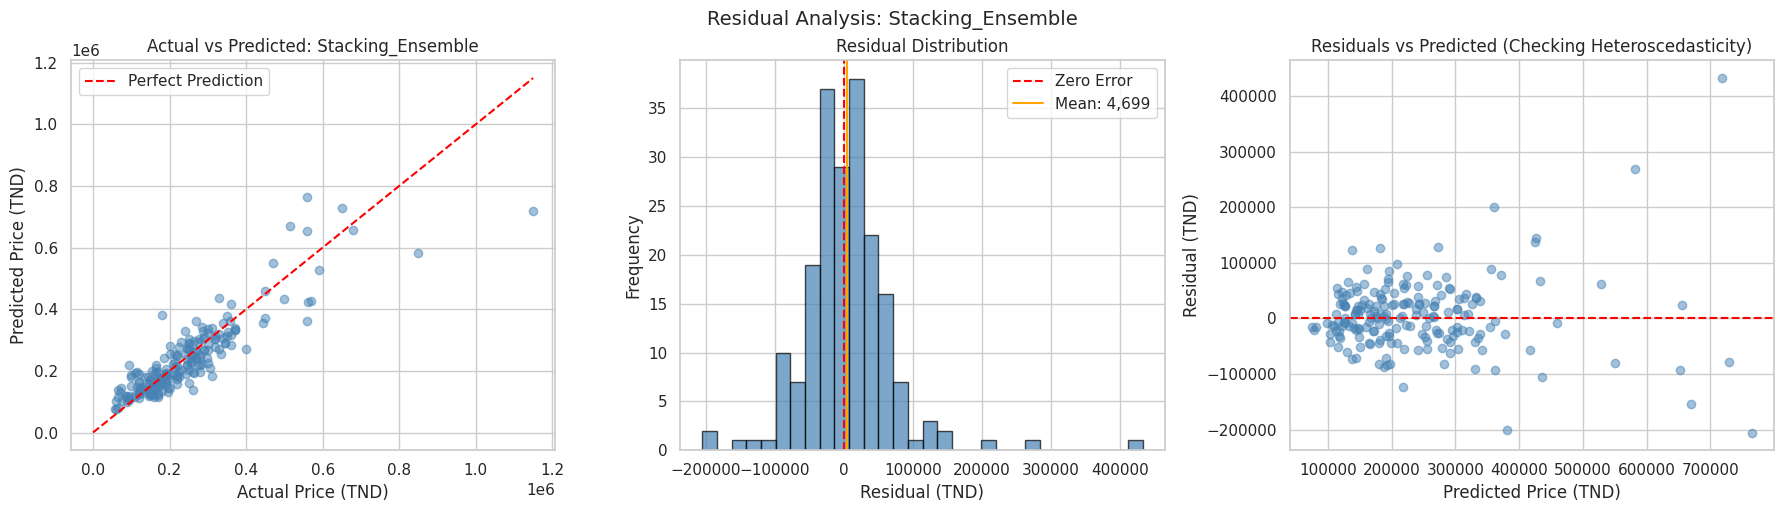


Residual Statistics:
  Mean Error: 4,699 TND
  Std Error: 65,336 TND
  Median Error: 3,639 TND


In [188]:
# --- Residual Analysis for Best Model ---
y_pred_best = best_model.predict(X_test)
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_best)
residuals = y_test_real - y_pred_real

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Actual vs Predicted
ax1 = axes[0]
ax1.scatter(y_test_real, y_pred_real, alpha=0.5, c='steelblue')
max_val = max(y_test_real.max(), y_pred_real.max())
ax1.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
ax1.set_xlabel('Actual Price (TND)')
ax1.set_ylabel('Predicted Price (TND)')
ax1.set_title(f'Actual vs Predicted: {best_model_name}')
ax1.legend()

# Plot 2: Residual Distribution
ax2 = axes[1]
ax2.hist(residuals, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', label='Zero Error')
ax2.axvline(x=residuals.mean(), color='orange', linestyle='-', label=f'Mean: {residuals.mean():,.0f}')
ax2.set_xlabel('Residual (TND)')
ax2.set_ylabel('Frequency')
ax2.set_title('Residual Distribution')
ax2.legend()

# Plot 3: Residuals vs Predicted (Heteroscedasticity Check)
ax3 = axes[2]
ax3.scatter(y_pred_real, residuals, alpha=0.5, c='steelblue')
ax3.axhline(y=0, color='red', linestyle='--')
ax3.set_xlabel('Predicted Price (TND)')
ax3.set_ylabel('Residual (TND)')
ax3.set_title('Residuals vs Predicted (Checking Heteroscedasticity)')

plt.tight_layout()
plt.suptitle(f'Residual Analysis: {best_model_name}', y=1.02, fontsize=14)
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean Error: {residuals.mean():,.0f} TND")
print(f"  Std Error: {residuals.std():,.0f} TND")
print(f"  Median Error: {residuals.median():,.0f} TND")

In [189]:
# --- 5.1 Bias-Variance Analysis Summary (Dynamic) ---
from IPython.display import display, Markdown
from sklearn.model_selection import cross_val_score

def generate_bias_variance_summary(model_results, best_estimators, X_train, y_train):
    """Generate dynamic bias-variance analysis from model results
    
    Bias-Variance decomposition (using CV scores as proxies):
    - Bias Indicator = max(0, 1 - CV_Train_R²) 
      → High value means model can't fit training data well (underfitting)
    - Variance Indicator = |CV_Train_R² - CV_Test_R²| (absolute value, always non-negative)
      → High value means unstable performance between train/test
    """
    
    # Include base models AND ensemble models
    analysis_models = ['RandomForest', 'GradientBoosting', 'SVR', 'Ridge', 'ElasticNet', 
                       'Voting_Ensemble', 'Stacking_Ensemble']
    model_analysis = []
    
    for model_name in analysis_models:
        if model_name in model_results:
            # Use the pre-computed values from GridSearchCV if available
            cv_train_r2 = model_results[model_name].get('CV_Train_R2', None)
            cv_test_r2 = model_results[model_name].get('CV_Test_R2', None)
            
            # For ensemble models, compute CV scores if not available
            if (cv_train_r2 is None or (isinstance(cv_train_r2, float) and np.isnan(cv_train_r2))) and model_name in best_estimators:
                print(f"Computing CV scores for {model_name}...")
                model = best_estimators[model_name]
                
                # Compute cross-validation scores
                cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
                cv_test_r2 = cv_scores.mean()
                
                # For ensemble train score, fit and predict on training data
                model.fit(X_train, y_train)
                y_train_pred = model.predict(X_train)
                cv_train_r2 = r2_score(y_train, y_train_pred)
                
                # Update model_results for future reference
                model_results[model_name]['CV_Train_R2'] = cv_train_r2
                model_results[model_name]['CV_Test_R2'] = cv_test_r2
                model_results[model_name]['CV_Std'] = cv_scores.std()
            
            if cv_train_r2 is not None and cv_test_r2 is not None:
                # Skip if NaN
                if isinstance(cv_train_r2, float) and np.isnan(cv_train_r2):
                    continue
                if isinstance(cv_test_r2, float) and np.isnan(cv_test_r2):
                    continue
                
                # Bias: How well the model fits training data (1 - train score)
                # Use max(0, ...) to ensure non-negative (train R² can exceed 1 in rare cases)
                bias_indicator = max(0, 1 - cv_train_r2)
                
                # Variance: Gap between train and test CV scores
                # Use absolute value to ensure non-negative 
                # (test can exceed train due to CV variance - this indicates good generalization)
                raw_gap = cv_train_r2 - cv_test_r2
                variance_indicator = abs(raw_gap)
                
                # Diagnose the model
                if raw_gap > 0.08:
                    diagnosis = "**Overfitting** (train >> test)"
                elif raw_gap < -0.03:
                    diagnosis = "Good generalization (test > train)"
                elif variance_indicator < 0.03 and bias_indicator > 0.15:
                    diagnosis = "**Underfitting** (high bias)"
                elif variance_indicator < 0.05 and bias_indicator < 0.15:
                    diagnosis = "**Best balance**"
                else:
                    diagnosis = "Good fit"
                
                model_analysis.append({
                    'Model': model_name,
                    'CV_Train_R2': cv_train_r2,
                    'CV_Test_R2': cv_test_r2,
                    'Bias': bias_indicator,
                    'Variance': variance_indicator,
                    'Raw_Gap': raw_gap,
                    'Diagnosis': diagnosis,
                    'Is_Ensemble': model_name in ['Voting_Ensemble', 'Stacking_Ensemble']
                })
    
    # Build markdown table - separate base models and ensembles
    md_content = "### 5.1 Bias-Variance Analysis Summary\n\n"
    md_content += "**Understanding the metrics:**\n"
    md_content += "- **Bias** = max(0, 1 - CV_Train_R²) → high = underfitting\n"
    md_content += "- **Variance** = |CV_Train_R² - CV_Test_R²| → high = unstable fit\n"
    md_content += "- **Gap** = CV_Train_R² - CV_Test_R² → positive = overfitting, negative = good generalization\n\n"
    
    # Base models table
    base_models = [m for m in model_analysis if not m['Is_Ensemble']]
    if base_models:
        md_content += "#### Base Models\n"
        md_content += "| Model | CV Train R² | CV Test R² | Bias | Variance | Gap | Diagnosis |\n"
        md_content += "|-------|-------------|------------|------|----------|-----|----------|\n"
        for model in base_models:
            gap_str = f"{model['Raw_Gap']:+.3f}"
            md_content += f"| {model['Model']} | {model['CV_Train_R2']:.4f} | {model['CV_Test_R2']:.4f} | {model['Bias']:.3f} | {model['Variance']:.3f} | {gap_str} | {model['Diagnosis']} |\n"
    
    # Ensemble models table
    ensemble_models = [m for m in model_analysis if m['Is_Ensemble']]
    if ensemble_models:
        md_content += "\n#### Ensemble Models\n"
        md_content += "| Model | CV Train R² | CV Test R² | Bias | Variance | Gap | Diagnosis |\n"
        md_content += "|-------|-------------|------------|------|----------|-----|----------|\n"
        for model in ensemble_models:
            gap_str = f"{model['Raw_Gap']:+.3f}"
            md_content += f"| {model['Model']} | {model['CV_Train_R2']:.4f} | {model['CV_Test_R2']:.4f} | {model['Bias']:.3f} | {model['Variance']:.3f} | {gap_str} | {model['Diagnosis']} |\n"
    
    # Find best balanced model (lowest combined bias + variance)
    if model_analysis:
        sorted_models = sorted(model_analysis, key=lambda x: x['Bias'] + x['Variance'])
        best_model = sorted_models[0]['Model']
        best_base = sorted([m for m in model_analysis if not m['Is_Ensemble']], 
                          key=lambda x: x['Bias'] + x['Variance'])[0]['Model'] if base_models else None
    else:
        best_model = "Unknown"
        best_base = None
    
    md_content += "\n**Key Observations:**\n"
    
    # Compare ensemble vs base models
    if ensemble_models and base_models:
        best_ensemble = min(ensemble_models, key=lambda x: x['Variance'])
        best_base_model = min(base_models, key=lambda x: x['Variance'])
        
        if best_ensemble['Variance'] < best_base_model['Variance']:
            md_content += f"1. **{best_ensemble['Model']}** has lower variance ({best_ensemble['Variance']:.3f}) than the best base model ({best_base_model['Model']}: {best_base_model['Variance']:.3f})\n"
        else:
            md_content += f"1. {best_base_model['Model']} has lower variance than ensembles\n"
    
    # Find high variance (overfitting) models - only if gap is positive
    high_var_models = [m for m in model_analysis if m['Raw_Gap'] > 0.08]
    if high_var_models:
        md_content += f"2. {high_var_models[0]['Model']} shows overfitting (gap = +{high_var_models[0]['Raw_Gap']:.3f})\n"
    
    # Find high bias (underfitting) models  
    high_bias_models = [m for m in model_analysis if m['Bias'] > 0.15]
    if high_bias_models:
        md_content += f"3. {high_bias_models[0]['Model']} shows higher bias (bias = {high_bias_models[0]['Bias']:.3f})\n"
    
    md_content += f"4. **{best_model}** shows the best overall bias-variance tradeoff\n"
    
    # Ensemble benefit analysis
    if 'Voting_Ensemble' in model_results and 'Stacking_Ensemble' in model_results:
        voting_r2 = model_results['Voting_Ensemble'].get('R2_Test', 0)
        stacking_r2 = model_results['Stacking_Ensemble'].get('R2_Test', 0)
        md_content += f"\n**Ensemble Comparison:**\n"
        md_content += f"- Voting Ensemble R² = {voting_r2:.4f}\n"
        md_content += f"- Stacking Ensemble R² = {stacking_r2:.4f}\n"
        if stacking_r2 > voting_r2:
            md_content += f"- Stacking outperforms Voting by {(stacking_r2-voting_r2)*100:.2f}%\n"
        else:
            md_content += f"- Voting outperforms Stacking by {(voting_r2-stacking_r2)*100:.2f}%\n"
    
    return md_content

# Generate and display
display(Markdown(generate_bias_variance_summary(model_results, best_estimators, X_train, y_train)))

Computing CV scores for Voting_Ensemble...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Computing CV scores for Stacking_Ensemble...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### 5.1 Bias-Variance Analysis Summary

**Understanding the metrics:**
- **Bias** = max(0, 1 - CV_Train_R²) → high = underfitting
- **Variance** = |CV_Train_R² - CV_Test_R²| → high = unstable fit
- **Gap** = CV_Train_R² - CV_Test_R² → positive = overfitting, negative = good generalization

#### Base Models
| Model | CV Train R² | CV Test R² | Bias | Variance | Gap | Diagnosis |
|-------|-------------|------------|------|----------|-----|----------|
| RandomForest | 0.9178 | 0.7680 | 0.082 | 0.150 | +0.150 | **Overfitting** (train >> test) |
| GradientBoosting | 0.9011 | 0.7877 | 0.099 | 0.113 | +0.113 | **Overfitting** (train >> test) |
| SVR | 0.8675 | 0.7709 | 0.132 | 0.097 | +0.097 | **Overfitting** (train >> test) |
| Ridge | 0.7981 | 0.7559 | 0.202 | 0.042 | +0.042 | Good fit |
| ElasticNet | 0.6660 | 0.6587 | 0.334 | 0.007 | +0.007 | **Underfitting** (high bias) |

#### Ensemble Models
| Model | CV Train R² | CV Test R² | Bias | Variance | Gap | Diagnosis |
|-------|-------------|------------|------|----------|-----|----------|
| Voting_Ensemble | 0.8687 | 0.7983 | 0.131 | 0.070 | +0.070 | Good fit |
| Stacking_Ensemble | 0.8842 | 0.7962 | 0.116 | 0.088 | +0.088 | **Overfitting** (train >> test) |

**Key Observations:**
1. ElasticNet has lower variance than ensembles
2. RandomForest shows overfitting (gap = +0.150)
3. Ridge shows higher bias (bias = 0.202)
4. **Voting_Ensemble** shows the best overall bias-variance tradeoff

**Ensemble Comparison:**
- Voting Ensemble R² = 0.7721
- Stacking Ensemble R² = 0.7725
- Stacking outperforms Voting by 0.04%
